In [2]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.dirname(os.path.abspath(current_dir)))
from Grover.grover_num_list_cirq import find_num, find_num_list
from Backend.fake_backend import FakeBackend
from Backend.backend import Backend
from Backend.ibm_backend import IBM_backend

from Result.result import ResultData

from qiskit.visualization import plot_histogram, plot_coupling_map
from qiskit import transpile
from qiskit.transpiler.passes import RemoveBarriers

from itertools import permutations

from SaveData.save_data_to_file import CSVWriter
import time

In [3]:
draw_circuit = False

In [4]:
# Sample of Finding a number in a list Grover circuit
winner_list = [4]
num_array = [0, 5, 7, 4]
find_num_in_data = find_num_list()
find_num_in_data.build_iteration(winner_list=winner_list, num_array=num_array, block_diagram=False, default_value=0)
find_num_in_data.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
cur_experiments = find_num_in_data.measure_qc
print(f"Number of Grover circuits : {len(cur_experiments)}")
print(f"Circuit Depth is : {cur_experiments[0].depth()}")
cur_experiments[0].draw('mpl') if draw_circuit else None

Number of Grover circuits : 1
Circuit Depth is : 36


In [5]:
# Sample of Find Number Grover Circuit
find_num_in_world_obj =  find_num()
winner_list = [6]
num_array = []
find_num_in_world_obj.build_iteration(winner_num_list=[6], circuit_nqubits=3, block_diagram=False)
find_num_in_world_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
cur_experiments = find_num_in_world_obj.measure_qc
print(f"Number of Grover circuits : {len(cur_experiments)}")
print(f"Circuit Depth is : {cur_experiments[0].depth()}")
cur_experiments[0].draw('mpl') if draw_circuit else None

Number of Grover circuits : 1
Circuit Depth is : 26


In [6]:
# Getting the Fake backend List
FakeBackend.get_ibm_fake_backend_name_list()

['FakeAlgiers',
 'FakeAlmaden',
 'FakeAlmadenV2',
 'FakeArmonk',
 'FakeArmonkV2',
 'FakeAthens',
 'FakeAthensV2',
 'FakeAuckland',
 'FakeBelem',
 'FakeBelemV2',
 'FakeBoeblingen',
 'FakeBoeblingenV2',
 'FakeBogota',
 'FakeBogotaV2',
 'FakeBrisbane',
 'FakeBrooklyn',
 'FakeBrooklynV2',
 'FakeBurlington',
 'FakeBurlingtonV2',
 'FakeCairo',
 'FakeCairoV2',
 'FakeCambridge',
 'FakeCambridgeAlternativeBasis',
 'FakeCambridgeV2',
 'FakeCasablanca',
 'FakeCasablancaV2',
 'FakeCusco',
 'FakeEssex',
 'FakeEssexV2',
 'FakeFractionalBackend',
 'FakeGeneva',
 'FakeGuadalupe',
 'FakeGuadalupeV2',
 'FakeHanoi',
 'FakeHanoiV2',
 'FakeJakarta',
 'FakeJakartaV2',
 'FakeJohannesburg',
 'FakeJohannesburgV2',
 'FakeKawasaki',
 'FakeKolkata',
 'FakeKolkataV2',
 'FakeKyiv',
 'FakeKyoto',
 'FakeLagos',
 'FakeLagosV2',
 'FakeLima',
 'FakeLimaV2',
 'FakeLondon',
 'FakeLondonV2',
 'FakeManhattan',
 'FakeManhattanV2',
 'FakeManila',
 'FakeManilaV2',
 'FakeMelbourne',
 'FakeMelbourneV2',
 'FakeMontreal',
 'FakeMo

In [7]:
# Getting the Fake backend List with qubit limits
FakeBackend.get_ibm_fake_backend_names_with_limit(20, 30)

['fake_algiers',
 'fake_almaden',
 'fake_auckland',
 'fake_boeblingen',
 'fake_cairo',
 'fake_cambridge',
 'fake_geneva',
 'fake_hanoi',
 'fake_johannesburg',
 'fake_kolkata',
 'fake_montreal',
 'fake_mumbai',
 'fake_paris',
 'fake_peekskill',
 'fake_poughkeepsie',
 'fake_singapore',
 'fake_sydney',
 'fake_toronto']

In [8]:
# Get Fake Backend by name
FakeBackend.get_ibm_fake_backend('fake_auckland')

In [9]:
aer_backend = Backend()

In [10]:
# Using qiskit Transpile with optimaztion level 0 = No opt
transpiled_circuit_aer_opt_0 = transpile(cur_experiments[0], aer_backend.get_backend(), optimization_level=0)
print(f"Trasnpiled circuit depth : {transpiled_circuit_aer_opt_0.depth()}")
transpiled_circuit_aer_opt_0.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 62


In [11]:
# Using qiskit Transpile with optimaztion level 3 = Max opt
transpiled_circuit_aer_opt_3 = transpile(cur_experiments[0], aer_backend.get_backend(), optimization_level=3)
print(f"Trasnpiled circuit depth : {transpiled_circuit_aer_opt_3.depth()}")
transpiled_circuit_aer_opt_3.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 50


Execution time : 0.004502


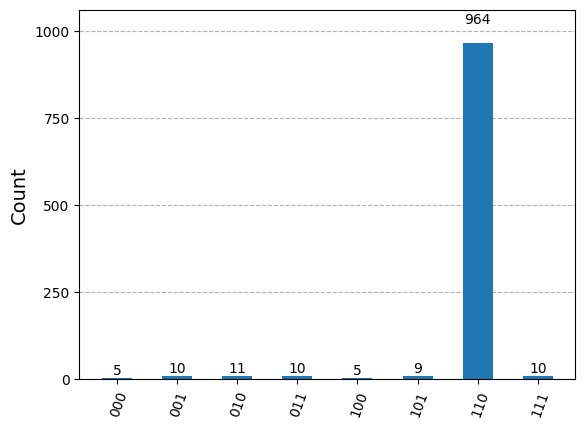

In [13]:
aer_job = aer_backend.run(transpiled_circuit_aer_opt_0)
aer_res = ResultData(aer_job)
print(f"Execution time : {aer_res.get_result_time_taken()}")
plot_histogram(aer_res.get_counts())

Execution time : 0.0042894


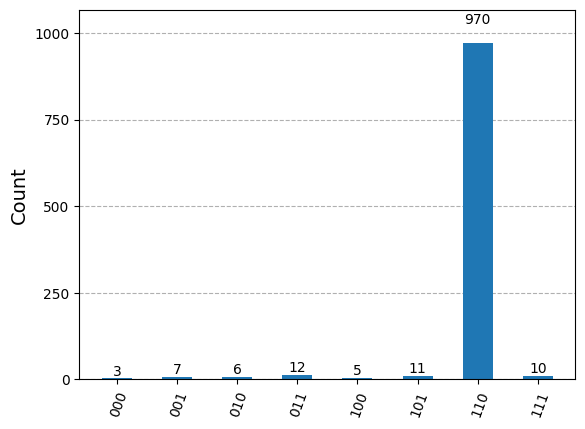

In [14]:
aer_job = aer_backend.run(transpiled_circuit_aer_opt_3)
aer_res = ResultData(aer_job)
print(f"Execution time : {aer_res.get_result_time_taken()}")
plot_histogram(aer_res.get_counts())

In [15]:
generic_backend = Backend(num_qubits=len(cur_experiments[0].qubits))

In [16]:
# Using qiskit Transpile with optimaztion level 0 = No opt
transpiled_circuit_generic_opt_0 = transpile(cur_experiments[0], generic_backend.get_backend(), optimization_level=0)
print(f"Trasnpiled circuit depth : {transpiled_circuit_generic_opt_0.depth()}")
transpiled_circuit_generic_opt_0.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 62


In [17]:
# Using qiskit Transpile with optimaztion level 3 = Max opt
transpiled_circuit_generic_opt_3 = transpile(cur_experiments[0], generic_backend.get_backend(), optimization_level=3)
print(f"Trasnpiled circuit depth : {transpiled_circuit_generic_opt_3.depth()}")
transpiled_circuit_generic_opt_3.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 60


Execution time : 0.0192815


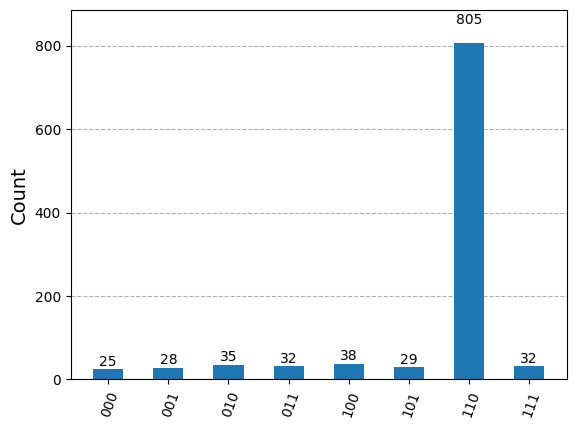

In [18]:
generic_job = generic_backend.run(transpiled_circuit_generic_opt_0)
generic_res = ResultData(generic_job)
print(f"Execution time : {generic_res.get_result_time_taken()}")
plot_histogram(generic_res.get_counts())

Execution time : 0.0140381


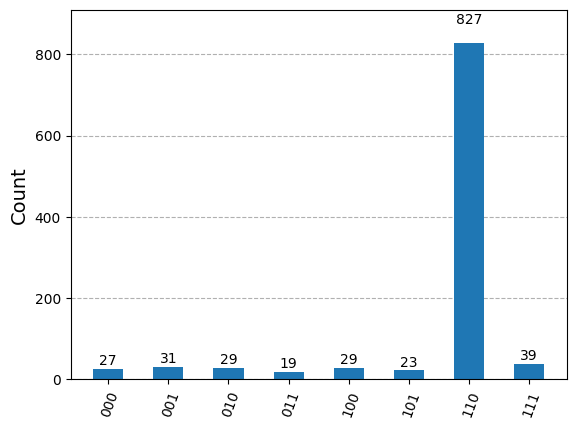

In [19]:
generic_job = generic_backend.run(transpiled_circuit_generic_opt_3)
generic_res = ResultData(generic_job)
print(f"Execution time : {generic_res.get_result_time_taken()}")
plot_histogram(generic_res.get_counts())

In [20]:
fake_backend_name = 'fake_auckland'
fake_backend = FakeBackend(fake_backend_name)

In [21]:
# Using qiskit Transpile with optimaztion level 0 = No opt
transpiled_circuit_fake_opt_0 = transpile(cur_experiments[0], fake_backend.get_backend(), optimization_level=0)
print(f"Trasnpiled circuit depth : {transpiled_circuit_fake_opt_0.depth()}")
transpiled_circuit_fake_opt_0.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 128


In [24]:
# Using qiskit Transpile with optimaztion level 3 = Max opt
transpiled_circuit_fake_opt_3 = transpile(cur_experiments[0], fake_backend.get_backend(), optimization_level=3)
print(f"Trasnpiled circuit depth : {transpiled_circuit_fake_opt_3.depth()}")
transpiled_circuit_fake_opt_3.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 89


Execution time : 0.0208254


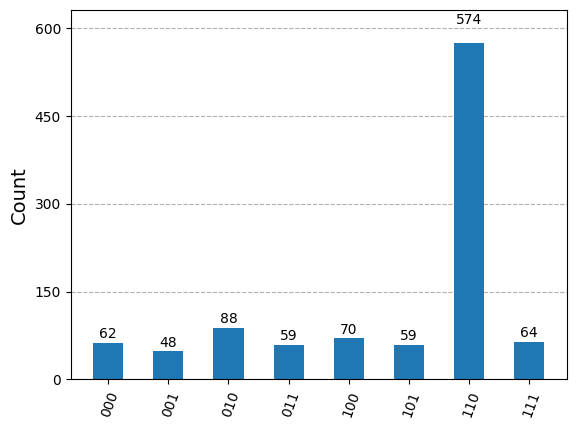

In [25]:
fake_job = fake_backend.run(transpiled_circuit_fake_opt_0)
fake_res = ResultData(fake_job)
print(f"Execution time : {fake_res.get_result_time_taken()}")
plot_histogram(fake_res.get_counts())

Execution time : 0.0054447


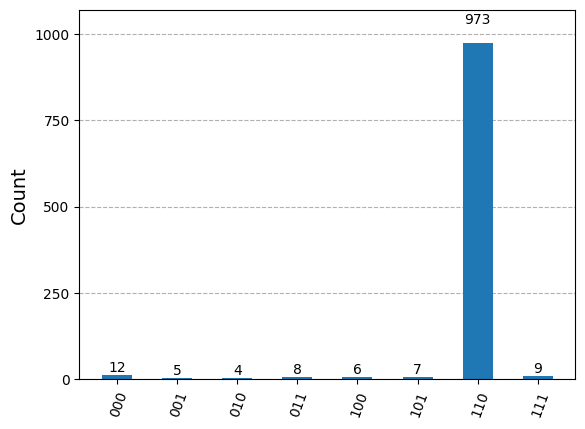

In [26]:
fake_job = generic_backend.run(transpiled_circuit_fake_opt_3)
fake_res = ResultData(fake_job)
print(f"Execution time : {fake_res.get_result_time_taken()}")
plot_histogram(fake_res.get_counts())

In [10]:
find_num_obj = find_num()
num_qubits = 3
experiments = []
seed = 42

aer_backend = Backend()
generic_backend = None # Backend(num_qubits=num_qubits)
fake_backend = FakeBackend('fake_auckland')

backend_list = [b_end for b_end in [aer_backend, generic_backend, fake_backend] if b_end is not None]

input_search_val = []
for value in range(2**num_qubits):
    if value != 6:
        continue
    input_search_val.append(value)
    find_num_obj.build_iteration(winner_num_list=[value], circuit_nqubits=num_qubits, block_diagram=False)
    find_num_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
    experiments.append(find_num_obj.measure_qc[0])

In [11]:
qc_without_barriar_list = [RemoveBarriers()(qc) for qc in experiments]

In [12]:
position_layout_addition = [] # list(permutations([11,16,13], num_qubits))

In [17]:
length = 10
seed = 42
total_start_time = time.time()

# Running on all circuits without barriars
for input_val, cur_qc in zip(input_search_val, qc_without_barriar_list):
    input_dict = {'input_search' : input_val}
    # Running on all backends
    position_layout = [None] + list(permutations(range(cur_qc.num_qubits), cur_qc.num_qubits)) + position_layout_addition
    perm_index = 0
    # Running on all layouts
    # Note : Each length, will save the file to excell
    while perm_index < len(position_layout):
        qc_transpiled_list = []
        cur_perm_list = position_layout[perm_index : perm_index + length]
        print(f"Running from index {perm_index} to {perm_index + length} of position layout\n")
        for cur_backend in backend_list:
            for index, layout in enumerate(cur_perm_list):
                # Running on all opt levels
                for opt_level in [0,3]:
                    start_time = time.time()
                    qc_transpiled_list.append(cur_backend.transpile_save_param(qc=cur_qc, optimization_level=opt_level, initial_layout=layout, seed_transpiler=None, 
                                                                            **input_dict))
                    print(f"Finished circuit with Opt {opt_level} for layout {layout} indexed {index} for current loop for backend {cur_backend.get_backend().name} in {round(time.time() - start_time, 3)} Seconds")
        # Running circuits with seeds
        run_start_time = time.time()
        qc_run_result = []
        data_save = []
        for index, qc in enumerate(qc_transpiled_list):
            for seed_val in [None, seed]:
                start_time = time.time()
                qc_result = qc.backend.run(qc.transpiled_qc, shots = 1024, seed_simulator = seed_val)
                qc_result = ResultData(qc_result)
                qc_result.set_seed(seed_val)
                data_save.append([qc, qc_result])
                print(f"Finished running circuit indexed {index} out of {len(qc_transpiled_list)} with seed {seed_val} in {round(time.time() - start_time,4)}  Seconds")
        print(f"Finished running all circuits in {round(time.time() - run_start_time,4)}  Seconds")
        # Saving file for each circuit
        start_time = time.time()
        additional_txt = ""
        for key, value in input_dict.items():
            additional_txt = additional_txt + f"_K{key}_V{value}"
        excel_name = f"grover_results{additional_txt}.csv"
        save = CSVWriter(file_name=excel_name)
        save.save_data(data_save)
        print(f"Finished saving to csv at {round(time.time() - start_time,4)} seconds\n")
        perm_index = perm_index + length
print(f"### Finished all circuits in all configurations in {time.time() - total_start_time} Seconds ###")

Running from index 0 to 100 of position layout

Finished circuit with Opt 0 for layout None indexed 0 for current loop for backend aer_simulator in 0.039 Seconds
Finished circuit with Opt 3 for layout None indexed 0 for current loop for backend aer_simulator in 0.082 Seconds
Finished circuit with Opt 0 for layout (0, 1, 2) indexed 1 for current loop for backend aer_simulator in 0.032 Seconds
Finished circuit with Opt 3 for layout (0, 1, 2) indexed 1 for current loop for backend aer_simulator in 0.067 Seconds
Finished circuit with Opt 0 for layout (0, 2, 1) indexed 2 for current loop for backend aer_simulator in 0.026 Seconds
Finished circuit with Opt 3 for layout (0, 2, 1) indexed 2 for current loop for backend aer_simulator in 0.071 Seconds
Finished circuit with Opt 0 for layout (1, 0, 2) indexed 3 for current loop for backend aer_simulator in 0.022 Seconds
Finished circuit with Opt 3 for layout (1, 0, 2) indexed 3 for current loop for backend aer_simulator in 0.045 Seconds
Finished c

In [ ]:
# excel_path = "../logs"
excel_name = "grover_results.csv"

save = CSVWriter(file_name=excel_name)

data = []
for qc_transpile, res_data, res_data_seed in zip(qc_transpiled_list, qc_resultData, qc_resultData_seed):
    data.append([qc_transpile, res_data])  
    data.append([qc_transpile, res_data_seed])  

save.save_data(data)

Data saved to ..\logs\grover_results_2024_08_09_22_03_54.csv
